# Trabajo biometría

Alejandro Jesús González Santana

In [1]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

## Lectura de Archivos:

In [5]:
sample_path = r"\BaseDatosNISTsd09_pr"
sample_path = os.getcwd()+sample_path
files= os.listdir(sample_path)

samples = []

filesname = []
filesname_f = []
filesname_s = []

for file in files:
    sample = sample_path + '\\' + file + '\\' + file + '_01.png'
    filesname.append(sample)
    filesname_f.append(sample)
    sample2 = sample_path + '\\' + file + '\\' + file[:-1] + 's_01.png'
    filesname.append(sample2)
    filesname_s.append(sample2)

counter=0 
print(files)
for file in files:
    dir = sample_path +'\\'
    dir = dir + file + '\\'
    file2= os.listdir(dir)
    ruta=dir+'\\'+file2[0]
    sample = cv.imread(ruta)
    counter+=1

    for file in files:
        dir = sample_path +'\\'
        dir = dir + file + '\\'
        file2= os.listdir(dir)
        ruta=dir+'\\'+file2[1] 
        sample2 = cv.imread(ruta)

['crd_0811f', 'crd_0812f', 'crd_0813f', 'crd_0814f', 'crd_0815f', 'crd_0816f', 'crd_0817f', 'crd_0818f', 'crd_0819f', 'crd_0820f']


Para leer los archivos originales, se ha empleado el código de ejemplo que acompañaba al ejercicio.

## Hipótesis de Partida

En el documento entregado en la semana 9, propuse como hipótesis las siguientes:

Preprocesado:
-  Tomar las imágenes y umbralizarlas para filtrar información no necesaria.
- Para extraer la huella se podría obtener una matriz una vez aplicado umbrales para ver las zonas aisladas, dichas zonas serán las firmas y cosas que no queremos, así que tal vez podemos aplicar un filtro de distancia para transformar esas partes a blanco. Una vez transformadas a blanco, podemos recortar la imagen con más precisión en lugar de hacerlo de forma manual.
- Otra posible forma de preprocesar la imagen sería con el Laplaciano o los operadores de Sobel. 
- Otra de las ideas es recorrer la imagen con un kernel, y si en un área los valores distintos a cero no superan un número, el punto involucrado se convertiría en un 0.

Considero que para explicar el desarrollo de esta práctica de forma más clara, primero deberíamos centrarnos en la parte del preprocesamiento. 

In [ ]:
for file in filesname:

    sample = cv.imread(file, cv.IMREAD_GRAYSCALE)

    sample[sample<120] = 0
    sample[sample>=120] = 255

    def normalizar(image):
        maximo = np.max(image)
        minimo = np.min(image)
        dif = maximo-minimo
        image_norm = 255*(image.astype(np.float32)-minimo)/dif
        return image_norm

    laplacian = cv.Laplacian(sample, -1)

    laplacian_def = laplacian

    for i in range(laplacian_def.shape[0]):
        for j in range(len(laplacian_def[i])):
            #calcular i - 10, i + 10, j - 10, j + 10 y si alguno se sale de la matriz, ponerlo en el borde
            i_min = i - 10 if i - 10 >= 0 else 0
            i_max = i + 10 if i + 10 < laplacian_def.shape[0] else laplacian_def.shape[0]
            j_min = j - 10 if j - 10 >= 0 else 0
            j_max = j + 10 if j + 10 < len(laplacian_def[i]) else len(laplacian_def[i])

            if laplacian_def[i, j] != 0:
                if np.sum(laplacian_def[i_min:i_max, j_min:j_max] != 0) < 35:
                    laplacian_def[i, j] = 0


    #cv.imshow('Laplacian', normalizar(laplacian_def).astype(np.uint8))

    #cv.waitKey(0)
    #cv.destroyAllWindows()

La primera toma de contacto con la práctica fue la idea del código superior. En primer lugar, leemos la imagen y la umbralizamos según un valor fijo. El valor establecido inicialmente para este umbral fue 120. Si el valor es menor, se sustituye por 0 (negro), en caso contrario, se sustituye por 255 (blanco). Tras esto, se obtendría el laplaciano de la imagen para resaltar los bordes, tal y como habíamos visto en la primera parte del curso. Luego viene la parte que se intentó crear para hacer un filtrado automático de la huella.

La imagen resultante del laplaciano sería recorrida por filas y columnas para calcular los valores distintos de 0 en una ventana. Se calculan los límites del píxel actual para evitar salirse de la imagen y causar un error, especialmente si está en un borde. Si la suma de los píxeles de la región distintos a 0 (es decir, con parte de información) es menor a un umbral, esta posición se establece a 0 también.

Durante esta parte del trabajo, me guié principalmente comparando con la primera imagen. El resultado obtenido fue bueno como salida de este proceso. Sin embargo, el resto de las imágenes no arrojaron los mismos resultados, por lo que fue necesario seguir probando otras opciones. Aquí hay una comparación de resultados:

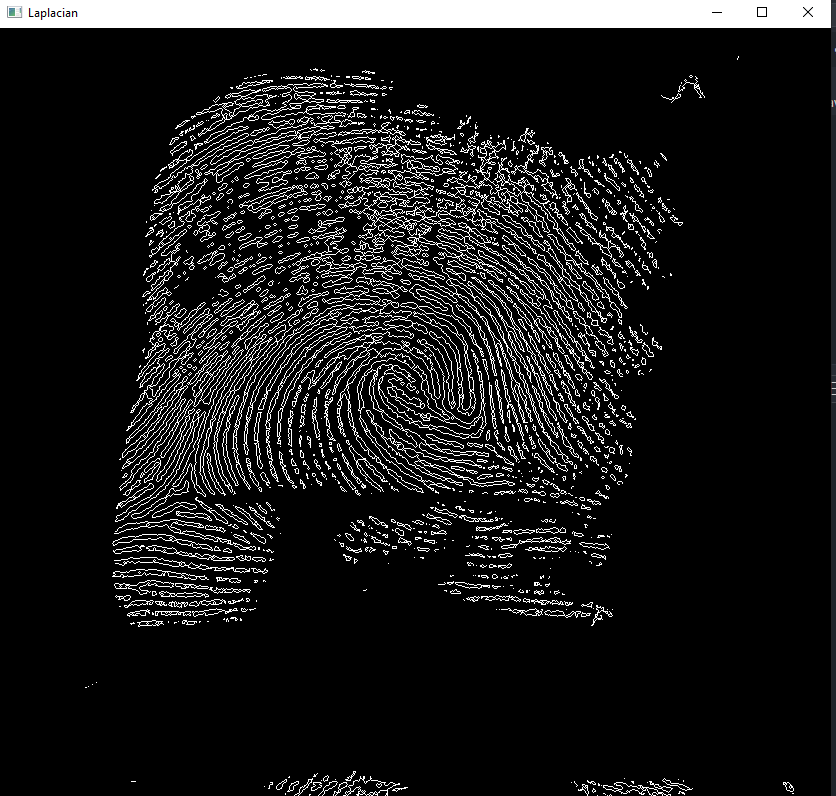
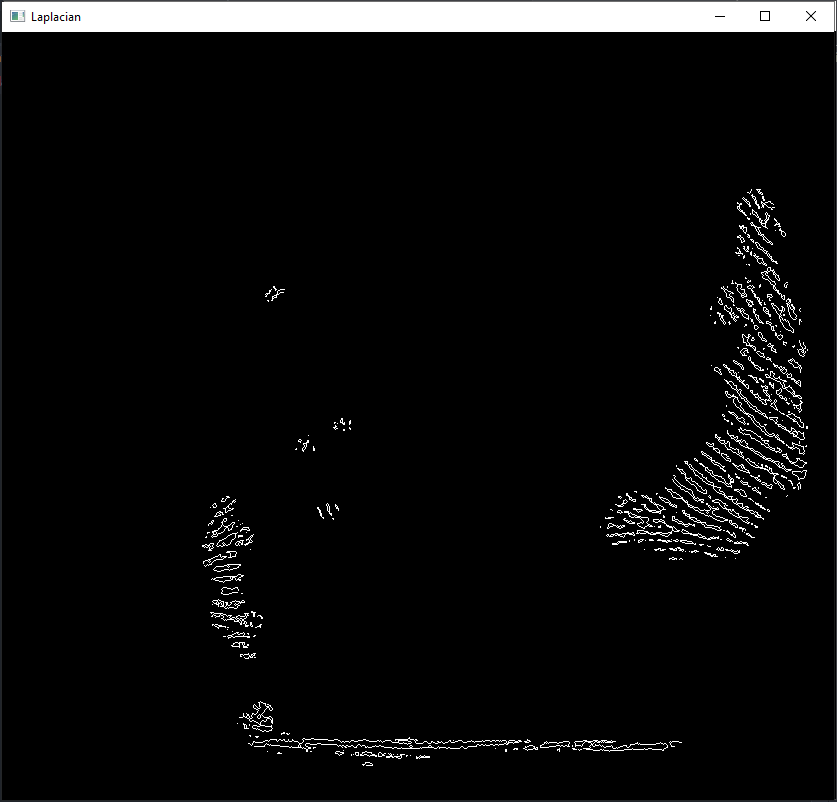

En ese momento consideré que el problema podría estar en el uso de un umbral fijo para umbralizar la imagen, lo que hacía que algunas imágenes apenas conservaran contenido. Al comprobarlo, confirmé que esa era la causa del problema.

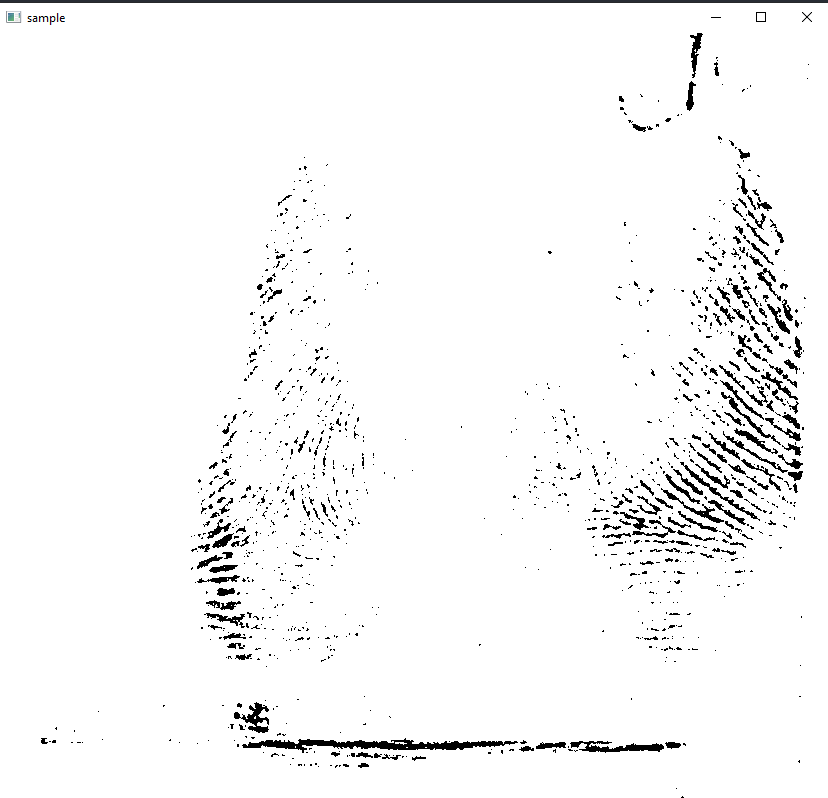

La idea fue umbralizar la imagen utilizando sus percentiles. Sin embargo, durante las pruebas surgieron problemas, ya que los valores de los cuantiles no eran fijos. Después de leer las imágenes, estas se invertían y su media se calculaba para compararla con una serie de valores que determinarían el cuantil a usar.

Se fijó un valor de comparación de la media en 175: si la media era menor, se utilizaba el cuantil 75 como referencia para umbralizar; en caso contrario, se aplicaba el cuantil 80. Una vez obtenido el valor correspondiente al cuantil de la imagen, esta se umbralizaba.

El resto del código se mantuvo igual, con la excepción de dos cambios: la ventana de influencia del píxel se amplió y el valor umbral se ajustó a 200.

In [ ]:
def get_laplacian(image):
    sample = cv.imread(image, cv.IMREAD_GRAYSCALE)

    sample_normalizado = normalizar(sample).astype(np.uint8)
    sample_normalizado = 255 - sample_normalizado  

    if sample_normalizado.mean() < 175:
        quantile = 75
    
    elif sample_normalizado.mean() >= 175:
        quantile = 80

    #obtener los cuartiles de la imagen
    q1 = np.percentile(sample_normalizado, quantile)

    sample_normalizado[sample_normalizado<q1] = 0
    sample_normalizado[sample_normalizado>=q1] = 255

    laplacian = cv.Laplacian(sample_normalizado, -1)

    current_sum = 0

    for i in range(laplacian.shape[0]):
        for j in range(len(laplacian[i])):

            i_min = i - 40 if i - 40 >= 0 else 0
            i_max = i + 40 if i + 40 < laplacian.shape[0] else laplacian.shape[0]
            j_min = j - 40 if j - 40 >= 0 else 0
            j_max = j + 40 if j + 40 < len(laplacian[i]) else len(laplacian[i])

            if laplacian[i, j] != 0:
                if np.sum(laplacian[i_min:i_max, j_min:j_max] != 0) < 200:
                    laplacian[i, j] = 0
                
                elif np.sum(laplacian[i_min:i_max, j_min:j_max] != 0) > current_sum:
                    current_sum = np.sum(laplacian[i_min:i_max, j_min:j_max])


    return laplacian

for i in range(len(filesname_f)):
    file_f = filesname_f[i]
    file_s = filesname_s[i]
    laplacian_f = get_laplacian(file_f)
    laplacian_s = get_laplacian(file_s)

    #cv.imshow('Laplacian f', normalizar(laplacian_f).astype(np.uint8))
    #cv.imshow('Laplacian s', normalizar(laplacian_s).astype(np.uint8))

    #cv.waitKey(0)
    #cv.destroyAllWindows()

Aunque las huellas ahora son más reconocibles, todavía no se eliminaban muchas de las marcas en las imágenes y seguían existiendo algunos casos que no se adaptaban bien, aunque en menor medida que antes.

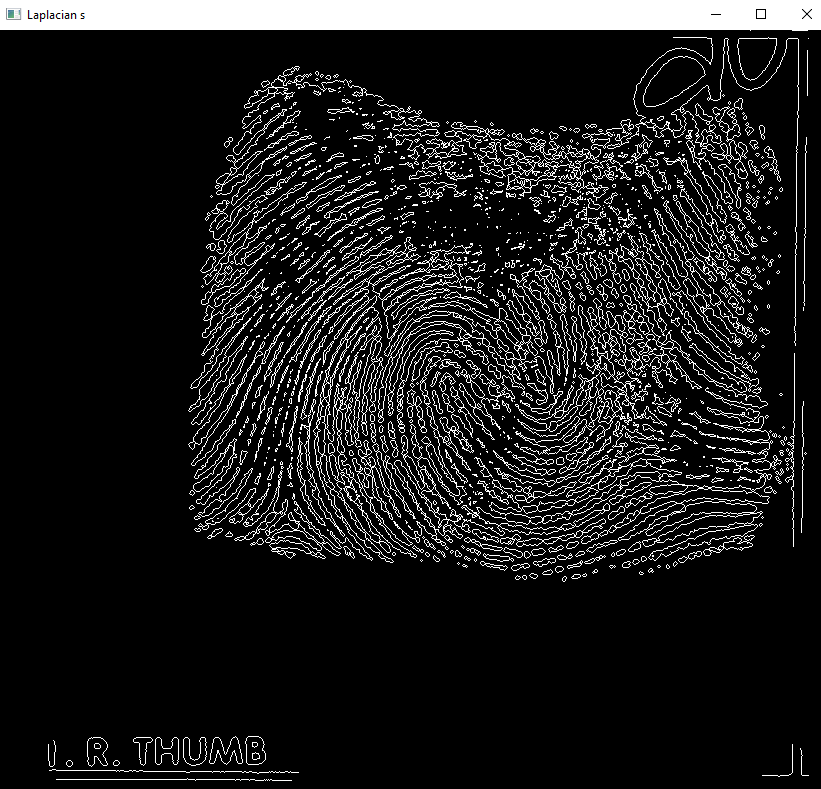

### Hipótesis alternativa preprocesamiento

Tras los comentarios en clase, consideré que sería una buena idea intentar recortar la imagen utilizando el histograma. Para ello, se creó la función find_max_region(). Esta función toma el histograma de una imagen y calcula la suma de frecuencias dentro de una ventana que se desplaza a lo largo del histograma.

La suma en cada posición se calcula restando la primera frecuencia de la ventana anterior, sumando el total del histograma y añadiendo la frecuencia correspondiente al nuevo elemento incluido en la ventana. Es importante señalar que la suma inicial se calcula para la primera ventana, y luego se itera utilizando el método descrito para el resto de las posiciones (por lo que el bucle comienza en la segunda posición).

Finalmente, se selecciona la posición inicial de la ventana con la mayor suma de valores, ya que esto indica que esa columna o fila contiene más información y es menos probable que corresponda a una firma u otro elemento añadido. La función devuelve la posición inicial y final de la ventana.

In [7]:
def find_max_region(histogram, window_size):

    max_sum = 0
    max_start = 0

    current_sum = np.sum(histogram[:window_size])


    for i in range(1, len(histogram) - window_size + 1):
        current_sum = current_sum - histogram[i - 1] + histogram[i + window_size - 1]

        if current_sum > max_sum:
            max_sum = current_sum
            max_start = i

    return max_start, max_start + window_size

Para umbralizar en este caso, se utiliza la función adaptiveThreshold con el fin de aplicar un umbral adaptativo. Los argumentos de la función son los siguientes:

- Valor a asignar a los píxeles que cumplan la condición (255).
- Método para ajustar el umbral en cada píxel. cv.ADAPTIVE_THRESH_GAUSSIAN_C establece que el valor de umbral es la suma ponderada (correlación cruzada con una ventana gaussiana) del vecindario de tamaño especificado (parámetro posterior) menos una constantes C (parámetro posterior también).
- El tipo de umbralización se fija en binaria (los valores se transforma en 0 o 255).
- 15 representa al tamaño de la vecindad usada para calcular el umbral adaptativo.
- 8 es el valor constante que se resta de la media ponderada para obtener el umbral. 

Este método resolvía uno de los principales problemas iniciales asociados a los umbrales fijos. El resultado de la umbralización se invierte posteriormente utilizando la función bitwise_not().

La función obtain_preprocessed_image encapsula todo el proceso. Primero, aplica la umbralización adaptativa e invierte la imagen. Luego, recorta la imagen usando los límites obtenidos para filas y columnas y, finalmente, ajusta el tamaño a 400x400 mediante la función resize."

In [3]:
def obtain_preprocessed_image(image):  

    umbralizada = cv.adaptiveThreshold(image, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv.THRESH_BINARY, 15, 8)
    
    umbralizada_inv = cv.bitwise_not(umbralizada)

    hist_filas = np.sum(umbralizada_inv, axis=1)

    hist_columnas = np.sum(umbralizada_inv, axis=0)


    fila_inicio, fila_fin = find_max_region(hist_filas, window_size=400)
    columna_inicio, columna_fin = find_max_region(hist_columnas, window_size=400)

    imagen_recortada = umbralizada_inv[fila_inicio:fila_fin, columna_inicio:columna_fin]

    imagen_recortada_resized = cv.resize(imagen_recortada, (400, 400))   

    return imagen_recortada_resized 

Se añadieron funciones para calcular la magnitud del gradiente utilizando el operador Sobel y para realzar los bordes mediante el Laplaciano. El objetivo era comparar los resultados obtenidos con nuestras primeras hipótesis sobre las imágenes. Las imágenes procesadas se almacenan en directorios separados para cada caso de estudio, lo que facilita seleccionar las más útiles para el entrenamiento.

## Sobel

In [2]:
def sobel_magnitude(image):
    sobel_x = cv.Sobel(image, cv.CV_64F, 1, 0, ksize=3)
    
    sobel_y = cv.Sobel(image, cv.CV_64F, 0, 1, ksize=3)
    
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    magnitude = np.uint8(np.clip(magnitude, 0, 255))
    
    return magnitude

## Laplaciano

In [3]:
def normalizar(image):
    maximo = np.max(image)
    minimo = np.min(image)
    dif = maximo-minimo
    image_norm = 255*(image.astype(np.float32)-minimo)/dif
    return image_norm

def get_laplacian(image):

    laplacian = cv.Laplacian(image, -1)

    return laplacian

## Guardar imágenes preprocesadas

In [10]:
import os

sobel_path = os.getcwd() + r'\sobel'
if not os.path.exists(sobel_path):
    os.makedirs(sobel_path)

preprocesado_path = os.getcwd() + r'\preprocesado'
if not os.path.exists(preprocesado_path):
    os.makedirs(preprocesado_path)

laplacian_path = os.getcwd() + r'\laplacian'
if not os.path.exists(laplacian_path):
    os.makedirs(laplacian_path)

In [11]:
for i in range(len(filesname_f)):
    file_f = filesname_f[i]
    file_s = filesname_s[i]

    img_f = cv.imread(file_f, cv.IMREAD_GRAYSCALE)
    img_s = cv.imread(file_s, cv.IMREAD_GRAYSCALE)

    img_f_pre = obtain_preprocessed_image(img_f)
    img_s_pre = obtain_preprocessed_image(img_s)

    laplacian_img_f_pre = cv.Laplacian(img_f_pre, -1)
    laplacian_img_s_pre = cv.Laplacian(img_s_pre, -1)


    sobel_magnitude_img_f_pre = sobel_magnitude(img_f_pre)
    sobel_magnitude_img_s_pre = sobel_magnitude(img_s_pre)


    #cv.imshow('img_f', img_f_pre)
    #cv.imshow('img_s', img_s_pre)

    #cv.imshow('laplacian_img_f_pre', laplacian_img_f_pre)
    #cv.imshow('laplacian_img_s_pre', laplacian_img_s_pre)

    #cv.imshow('sobel_magnitude_img_f_pre', sobel_magnitude_img_f_pre)
    #cv.imshow('sobel_magnitude_img_s_pre', sobel_magnitude_img_s_pre)

    #guardar imagenes
    sobel_f_path = sobel_path + '\\' + files[i] + '_01.png'
    sobel_s_path = sobel_path + '\\' + files[i][:-1] + 's_01.png'

    preprocesado_f_path = preprocesado_path + '\\' + files[i] + '_01.png'
    preprocesado_s_path = preprocesado_path + '\\' + files[i][:-1] + 's_01.png'

    laplacian_f_path = laplacian_path + '\\' + files[i] + '_01.png'
    laplacian_s_path = laplacian_path + '\\' + files[i][:-1] + 's_01.png'

    cv.imwrite(sobel_f_path, sobel_magnitude_img_f_pre)
    cv.imwrite(sobel_s_path, sobel_magnitude_img_s_pre)

    cv.imwrite(preprocesado_f_path, img_f_pre)
    cv.imwrite(preprocesado_s_path, img_s_pre)

    cv.imwrite(laplacian_f_path, laplacian_img_f_pre)
    cv.imwrite(laplacian_s_path, laplacian_img_s_pre)


    #cv.waitKey(0)
    #cv.destroyAllWindows()  

Al comparar las imágenes, el resultado sin aplicar transformaciones adicionales parece ser el más adecuado. De hecho, las imágenes obtenidas mediante Sobel y Laplaciano resultan menos apropiadas, ya que contienen más ruido al resaltar únicamente los bordes. Por lo tanto, las imágenes que se utilizarán para crear nuestro modelo de autenticación serán las de la carpeta preprocesada.

#### Imagen tras preprocesado:
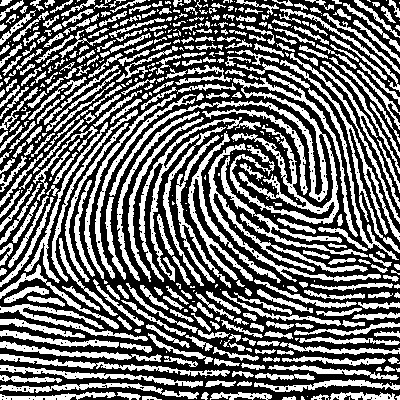

#### Imagen tras preprocesado y laplaciano:
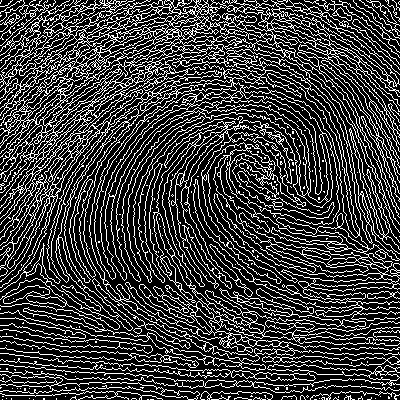

#### Imagen tras preprocesado y sobel:
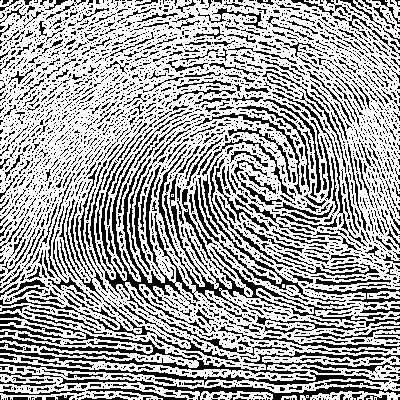

In [12]:
filesname_preprocess_f = []
filesname_preprocess_s = []

for file in files:
    filesname_preprocess_f.append(preprocesado_path + '\\' + file + '_01.png')
    filesname_preprocess_s.append(preprocesado_path + '\\' + file[:-1] + 's_01.png')

## Hipótesis de Partida Modelos

- Una primera hipótesis sería probar con SIFT a encontrar puntos de interés en otras entradas. En este caso el acierto se comprobaría con un número de buenos emparejamientos de puntos. Se establecería un umbral en base a la experimentación y se diría que a partir de un cierto número de acierto la muestra se corresponde con una imagen y por lo tanto se verificaría la identidad.
- Otra de las hipótesis sería poder crear una SVM donde se creen muestras etiquetadas. El problema de esta hipótesis podría ser que cada vez que se entrene el modelo debería hacerse con etiquetas binarias para cada usuario de forma personalizada. Sería una alternativa menos costosa que entrenar una red neuronal.

### Prueba inicial en clase

En la semana 10, se solicitó enviar un resultado inicial de las pruebas con uno de los modelos de autenticación, junto con su curva DET. El primer método considerado en la formulación de hipótesis fue SIFT. Lo habíamos estudiado recientemente y parecía aplicable a este problema, donde se requieren medidas de similitud entre dos imágenes para determinar si se aprueba o rechaza el acceso. La idea inicial consistió en aceptar el acceso si se alcanzaba un número suficiente de coincidencias válidas.

SIFT toma dos imágenes (en este caso, se comparaban los archivos 'f' frente a los 's'). Para cada una de ellas, se obtenía la imagen preprocesada (en ese momento, se trabajaba con la primera hipótesis de procesamiento). Se creaba el objeto SIFT y se detectaban los puntos clave y descriptores para cada imagen.

Para comparar las características se utiliza el BFMatcher, que es más exhaustivo que otros métodos como Flann. A continuación, se realiza una búsqueda de los vecinos más cercanos para encontrar las mejores coincidencias de los descriptores. La lista de matches contiene los emparejamientos, donde cada elemento incluye los dos mejores emparejamientos.

Para filtrar las buenas coincidencias, se compara la distancia del primer emparejamiento con la del segundo, siendo necesario que la distancia del primer emparejamiento sea al menos un 75% menor que la del segundo. Las buenas coincidencias se agregan a una lista. Si el tamaño de la lista supera un umbral, se considera que la imagen ha sido aceptada. En este caso, era fácil comparar las etiquetas, ya que solo se iteraba sobre archivos ordenados. Sin embargo, se observaron algunos errores al identificar las imágenes. Además, el código recopila los valores de los umbrales máximos para cada detección, los cuales se utilizaron posteriormente para la prueba y generación de la curva DET.

In [ ]:
error = 0
far = 0
faa = 0
values = []
good_matches_occurred = 0
for i in range(len(filesname_f) - 2):
    max = 0
    etiqueta_real = i
    for j in range(len(filesname_s)):

        if i == j:
            etiqueta = i

        file_f = filesname_f[i]
        file_s = filesname_s[j]
        laplacian_f = get_laplacian(file_f)
        laplacian_s = get_laplacian(file_s)    

        sift = cv.SIFT_create()
        kp1, des1 = sift.detectAndCompute(laplacian_f, None)
        kp2, des2 = sift.detectAndCompute(laplacian_s, None)

        bf = cv.BFMatcher()
        matches = bf.knnMatch(des1, des2, k=2)
        matches = sorted(matches, key = lambda x:x[1].distance)

        good = []

        for m, n in matches:
            if m.distance < 0.75*n.distance:
                good.append([m])
        
        if len(good) > max:
            max = len(good)
            etiqueta = j
    
        print("Good matches: ", len(good))
    
    if etiqueta_real != etiqueta:
        error += 1

    else:
        good_matches_occurred += 1
        values.append(max)
    print("Etiqueta real: ", etiqueta_real, " Etiqueta predicha: ", etiqueta)

print(good_matches_occurred)


Good matches:  14
Good matches:  27
Good matches:  21
Good matches:  17
Good matches:  14
Good matches:  15
Good matches:  10
Good matches:  20
Good matches:  19
Good matches:  37
Etiqueta real:  0  Etiqueta predicha:  9
Good matches:  27
Good matches:  31
Good matches:  26
Good matches:  22
Good matches:  23
Good matches:  20
Good matches:  22
Good matches:  18
Good matches:  27
Good matches:  19
Etiqueta real:  1  Etiqueta predicha:  1
Good matches:  33
Good matches:  41
Good matches:  23
Good matches:  36
Good matches:  20
Good matches:  51
Good matches:  26
Good matches:  26
Good matches:  32
Good matches:  23
Etiqueta real:  2  Etiqueta predicha:  5
Good matches:  40
Good matches:  22
Good matches:  29
Good matches:  21
Good matches:  29
Good matches:  33
Good matches:  26
Good matches:  29
Good matches:  29
Good matches:  35
Etiqueta real:  3  Etiqueta predicha:  3
Good matches:  42
Good matches:  31
Good matches:  22
Good matches:  31
Good matches:  29
Good matches:  29
Good mat

La función empleada para la prueba sería la siguiente:

In [ ]:
def apply_sift(img1, img2, umbral):

    file_f = filesname_f[i]
    file_s = filesname_s[j]
    laplacian_f = get_laplacian(file_f)
    laplacian_s = get_laplacian(file_s)    

    sift = cv.SIFT_create()
    kp1, des1 = sift.detectAndCompute(laplacian_f, None)
    kp2, des2 = sift.detectAndCompute(laplacian_s, None)

    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    matches = sorted(matches, key = lambda x:x[1].distance)

    good = []

    for m, n in matches:
        if m.distance < 0.75*n.distance:
            good.append([m])
    
    if len(good) > umbral:
        return True

    else:
        return False

Para realizar la prueba, generamos listas donde se almacenarán las tasas de falso rechazo (FRR) y de falsa aceptación (FAR). Recorremos los umbrales y calculamos ambas medidas para cada prueba. Para identificar la veracidad real de los accesos, comparamos los índices de los bucles, ya que los archivos 'f' y 's' se recorren en el mismo orden. En este caso, de los archivos de 'f' recorridos, dos se reservan para pruebas futuras. La función apply_sift devolverá verdadero si se concede el acceso. Si las etiquetas no coinciden y se concede acceso, estamos ante un intento no autorizado aceptado, lo que suma a FAR. Este valor se ajustará al final para representar correctamente su valor (de momento, representa los falsos positivos). Si las etiquetas coinciden y no se concede acceso, se contabiliza un falso negativo, que se usará para calcular FRR. Tras iterar sobre todos los archivos, se obtienen las tasas FAR y FRR dividiendo por el número de intentos no autorizados y autorizados, respectivamente.

La curva DET obtenida era de bastante baja calidad y no era interpretable, ya que parecía un triángulo. Una posible explicación es la dificultad para encontrar un umbral adecuado de buenas muestras.

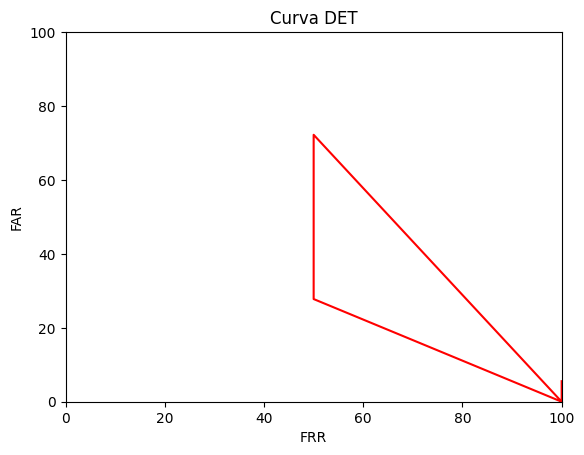


In [ ]:
far_total = []
frr_total = []
test_files = filesname_f[-2:]
umbral_mean = np.mean(values)

for umbral in values:
    far = 0
    frr = 0
    intentos_autorizados = 0
    intentos_no_autorizados = 0
    for i in range(len(test_files)):
        for j in range(len(filesname_s)):

            if i != j:
                if apply_sift(test_files[i], filesname_s[j], umbral):
                    far += 1
                intentos_no_autorizados += 1

            else:
                if not apply_sift(filesname_f[i], filesname_s[j], umbral):
                    frr += 1  
                intentos_autorizados += 1
    
    far_total.append((far/intentos_no_autorizados) * 100)
    frr_total.append((frr/intentos_autorizados) * 100)
    print("Siguiente umbral")


print(far_total)
print(frr_total)

umbrales = sorted(values)

plt.plot(frr_total, far_total, 'r-')
plt.xlabel('FRR')
plt.xlim(0, 100)
plt.ylabel('FAR')
plt.ylim(0, 100)
plt.title("Curva DET")
plt.show()

### Crear rotaciones para SIFT

Este paso es posterior a los nuevos intentos con SIFT, pero es necesario explicarlo para continuar con el desarrollo de la práctica. Durante el entrenamiento, se detectó una de las necesidades más importantes: la pequeña cantidad de muestras disponibles (un problema previamente comentado en clase). Para solventarlo, se creó la función rotate_image, que es capaz de rotar una imagen en tres ángulos (90, 180 y 270 grados). Esta función se desarrolló para aumentar el tamaño del conjunto de datos de entrenamiento para SIFT; sin embargo, el número de imágenes generadas no es demasiado alto debido al largo tiempo de ejecución, como veremos más adelante. Las imágenes se encuentran almacenadas en la carpeta rotated_path, que incluye las imágenes de los conjuntos 'f' y 's'. En el nombre de cada archivo se indica el ángulo de rotación que ha sufrido.

In [13]:
def rotate_image(image, angle):

    if angle == 90:
        rotated = cv.rotate(image, cv.ROTATE_90_CLOCKWISE)
    
    elif angle == 180:
        rotated = cv.rotate(image, cv.ROTATE_180)
    
    elif angle == 270:
        rotated = cv.rotate(image, cv.ROTATE_90_COUNTERCLOCKWISE)
    
    else:
        print("Ángulo no válido")
        return None
    
    return rotated


rotated_path = "rotated_images"
os.makedirs(rotated_path, exist_ok=True)


for file in filesname_preprocess_f + filesname_preprocess_s:
    print(file)
    image = cv.imread(file, cv.IMREAD_GRAYSCALE)

    angles = [90, 180, 270]
    for angle in angles:
        rotated = rotate_image(image, angle)

        filename = os.path.join(rotated_path, f"{os.path.basename(file)[:-4]}_{angle}.png")
        cv.imwrite(filename, rotated)

    filename = os.path.join(rotated_path, f"{os.path.basename(file)[:-4]}_0.png")
    image = cv.imread(file, cv.IMREAD_GRAYSCALE)
    cv.imwrite(filename, image)

d:\Alejandro\Documents\Universidad\Cuarto\PIAV\Practica semana 9\preprocesado\crd_0811f_01.png
d:\Alejandro\Documents\Universidad\Cuarto\PIAV\Practica semana 9\preprocesado\crd_0812f_01.png
d:\Alejandro\Documents\Universidad\Cuarto\PIAV\Practica semana 9\preprocesado\crd_0813f_01.png
d:\Alejandro\Documents\Universidad\Cuarto\PIAV\Practica semana 9\preprocesado\crd_0814f_01.png
d:\Alejandro\Documents\Universidad\Cuarto\PIAV\Practica semana 9\preprocesado\crd_0815f_01.png
d:\Alejandro\Documents\Universidad\Cuarto\PIAV\Practica semana 9\preprocesado\crd_0816f_01.png
d:\Alejandro\Documents\Universidad\Cuarto\PIAV\Practica semana 9\preprocesado\crd_0817f_01.png
d:\Alejandro\Documents\Universidad\Cuarto\PIAV\Practica semana 9\preprocesado\crd_0818f_01.png
d:\Alejandro\Documents\Universidad\Cuarto\PIAV\Practica semana 9\preprocesado\crd_0819f_01.png
d:\Alejandro\Documents\Universidad\Cuarto\PIAV\Practica semana 9\preprocesado\crd_0820f_01.png
d:\Alejandro\Documents\Universidad\Cuarto\PIAV\Pra

### Preprocesar imágenes rotadas

En el código anterior, trabajamos con los archivos originales sin procesar de la base de datos, por lo que es necesario aplicarles el preprocesado para recortar su tamaño y mejorar su nitidez. Estas nuevas imágenes se almacenan en una carpeta distinta para evitar repetir el preprocesado.

In [14]:
rotated_files = os.listdir(rotated_path)

pre_rotated_path = "preprocessed_rotated"

os.makedirs(pre_rotated_path, exist_ok=True)

for file in rotated_files:
    rotated_image = cv.imread(os.path.join(rotated_path, file), cv.IMREAD_GRAYSCALE)
    rotated_image_pre = obtain_preprocessed_image(rotated_image)

    cv.imwrite(os.path.join(pre_rotated_path, f"{file}"), rotated_image_pre)

### Nuevo enfoque de SIFT

En la primera prueba, observamos que una de las dificultades era encontrar un valor adecuado para el umbral. Nuevamente, creamos un objeto SIFT y obtenemos los puntos de interés junto con los descriptores utilizando detectAndCompute(). El emparejamiento por fuerza bruta se realiza usando como medida de similitud la norma L2 (la distancia euclidiana, que también se usó en la prueba anterior). El parámetro crossCheck asegura que los descriptores tengan un emparejamiento recíproco, lo cual puede ser una buena opción en aplicaciones de autenticación. Ahora, en lugar de comparar los emparejamientos con el criterio de Lowe (que compara las dos mejores coincidencias), podremos establecer un valor de distancia umbral para contar una coincidencia como buena. Para aceptar la imagen, su número de buenas coincidencias debe ser superior al 10% de los puntos clave obtenidos. Este valor se determinó a través de pruebas.

In [9]:
def apply_sift(img1, img2, umbral):

    sift = cv.SIFT_create()

    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)
    matches = bf.match(des1, des2)

    good = []

    for match in matches:
        if match.distance < umbral:
            good.append(match)


    if len(good) >= len(kp1) * 0.1:
        print("Número de coincidencias: ", len(good), "entre coincidencias posibles: ", len(kp1))
        return True
    else:
        print("Número de coincidencias: ", len(good), "entre coincidencias posibles: ", len(kp1))
        return False

### Aplicar SIFT

Leemos los archivos de la carpeta con las imágenes rotadas y creanmos listas para almacenar los valores necesarios para crear las curvas DET y AUC. Los valores que se probarán para el umbral de distancia se encuentran en la lista values. Los archivos se dividen en dos cojuntos de entrenamiento (80%) y test (20%). 

En este caso los archivos usados como referencia para el sistema serían los archivos f (menos los dos  últimos). Para el archivo f obtenemos su nombre y comparamos los primeros 8 carácteres con los del archivo de entrenamiento, esto nos permitirá conocer si se tratan de la misma huella (es la parte crd_0811, por ejemplo). El resto del proceso es muy similar al visto en la primera prueba, donde se van contando los casos cada vez el modelo devuelve su decisión de aceptación o rechazo comparando con la etiqueta real.

Los valores para la curva DET se calculan como:

- FAR (Tasa de Aceptación Falsa): (falsa aceptación / intentos no autorizados) * 100
- FRR (Tasa de Rechazo Falso): (falso rechazo / intentos autorizados) * 100

Los valores para la curva AUC son:

- TPR (Tasa de Verdaderos Positivos): (verdadera aceptación / (verdadera aceptación + falso rechazo)) * 100
- FPR (Tasa de Falsos Positivos): (falsa aceptación / (falsa aceptación + verdadero rechazo)) * 100 

Tras finalizar las iteraciones sobre los umbrales estos se guardaron en un archivo para poder acceder a ellos en otro momento. Esto se debe a que el tiempo de ejecución de este método es bastante largo (algo más de una hora).

In [89]:
from sklearn.model_selection import train_test_split

pre_rotated_path = "preprocessed_rotated"

pre_rotated_files = os.listdir(pre_rotated_path)


far_total_sift = []
frr_total_sift = []
tpr_total_sift = []
fpr_total_sift = []
intentos_autorizados = 0
intentos_no_autorizados = 0

values = [160, 200, 240, 280, 300, 320, 340, 360, 400, 440]
train_files, test_files = train_test_split(pre_rotated_files, test_size=0.2, random_state=42)


images_f = []
for file_f in filesname_f: 
    img_f = cv.imread(file_f, cv.IMREAD_GRAYSCALE)
    images_f.append(img_f)

images_train = []
for file in train_files:
    img = cv.imread(pre_rotated_path + "/" + file, cv.IMREAD_GRAYSCALE)
    images_train.append(img)

images_test = []
for file in test_files:
    img = cv.imread(pre_rotated_path + "/" + file, cv.IMREAD_GRAYSCALE)
    images_test.append(img)

for umbral in values:
    fa = 0
    fr = 0
    va = 0
    vr = 0

    intentos_autorizados = 0
    intentos_no_autorizados = 0
    for i in range(len(filesname_f[:-2])):
        for j in range(len(train_files)):

            file_f = filesname_f[i].split('\\')[-1]
            if file_f[:8] != train_files[j][:8]:
                if apply_sift(images_f[i], images_train[j], umbral):
                    fa += 1
                    #print("Intento no autorizado aceptado usando umbral: ", umbral)
                else:
                    vr += 1
                intentos_no_autorizados += 1

            else:
                if not apply_sift(images_f[i], images_train[j], umbral):
                    fr += 1  
                    #print("Intento autorizado rechazado usando umbral: ", umbral)
                else:
                    va += 1
                intentos_autorizados += 1
    
    print("Finalizado umbral: ", umbral)
    far_total_sift.append((fa/intentos_no_autorizados) * 100)
    frr_total_sift.append((fr/intentos_autorizados) * 100)
    tpr_total_sift.append((va/(va + fr)) * 100)
    fpr_total_sift.append((fa/(fa + vr)) * 100)


#guardar los valores obtenidos en un archivo
import os

with open("sift_values_train.txt", "w") as file:
    #guardar en cada línea la lista junto con lo que representa
    file.write("FAR\n")
    #escribir la lista como string
    file.write(str(far_total_sift) + "\n")
    file.write("FRR\n")
    file.write(str(frr_total_sift) + "\n")
    file.write("TPR\n")
    file.write(str(tpr_total_sift) + "\n")
    file.write("FPR\n")
    file.write(str(fpr_total_sift) + "\n")

Finalizado umbral:  160
Finalizado umbral:  200
Finalizado umbral:  240
Finalizado umbral:  280
Finalizado umbral:  300
Finalizado umbral:  320
Finalizado umbral:  340
Finalizado umbral:  360
Finalizado umbral:  400
Finalizado umbral:  440


### Valores para test

Se repiten los pasos anteriores para el conjunto de test.

In [90]:
far_total_sift = []
frr_total_sift = []
tpr_total_sift = []
fpr_total_sift = []

for umbral in values:
    fa = 0
    fr = 0
    va = 0
    vr = 0

    intentos_autorizados = 0
    intentos_no_autorizados = 0
    for i in range(2):
        for j in range(len(test_files)):

            file_f = filesname_f[i].split('\\')[-1]
            if file_f[:8] != test_files[j][:8]:
                if apply_sift(images_f[-i], images_test[j], umbral):
                    fa += 1
                    #print("Intento no autorizado aceptado usando umbral: ", umbral)
                else:
                    vr += 1
                intentos_no_autorizados += 1

            else:
                if not apply_sift(images_f[-i], images_test[j], umbral):
                    fr += 1  
                    #print("Intento autorizado rechazado usando umbral: ", umbral)
                else:
                    va += 1
                intentos_autorizados += 1
    
    print("Finalizado umbral: ", umbral)
    far_total_sift.append((fa / (intentos_no_autorizados if intentos_no_autorizados != 0 else 1)) * 100)
    frr_total_sift.append((fr / (intentos_autorizados if intentos_autorizados != 0 else 1)) * 100)

    tpr_total_sift.append((va/(va + fr)) * 100)
    fpr_total_sift.append((fa/(fa + vr)) * 100)

with open("sift_values_test.txt", "w") as file:
    #guardar en cada línea la lista junto con lo que representa
    file.write("FAR\n")
    #escribir la lista como string
    file.write(str(far_total_sift) + "\n")
    file.write("FRR\n")
    file.write(str(frr_total_sift) + "\n")
    file.write("TPR\n")
    file.write(str(tpr_total_sift) + "\n")
    file.write("FPR\n")
    file.write(str(fpr_total_sift) + "\n")

Finalizado umbral:  160
Finalizado umbral:  200
Finalizado umbral:  240
Finalizado umbral:  280
Finalizado umbral:  300
Finalizado umbral:  320
Finalizado umbral:  340
Finalizado umbral:  360
Finalizado umbral:  400
Finalizado umbral:  440


### Ver gráficas DET y ROC para SIFT

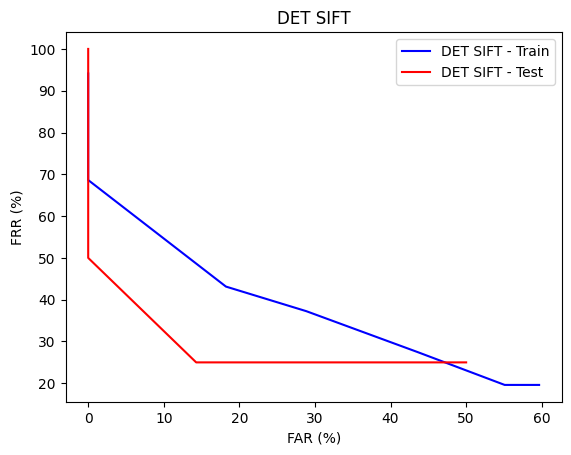

In [23]:
import matplotlib.pyplot as plt

# Valores de train
far_train = [0.0, 0.0, 0.0, 18.22125813449024, 28.850325379609544, 43.600867678958785, 55.09761388286334, 59.436008676789584, 59.65292841648589, 59.65292841648589]
frr_train = [94.11764705882352, 86.27450980392157, 68.62745098039215, 43.13725490196079, 37.254901960784316, 27.450980392156865, 19.607843137254903, 19.607843137254903, 19.607843137254903, 19.607843137254903]
tpr_train = [5.88235294117647, 13.725490196078432, 31.372549019607842, 56.86274509803921, 62.745098039215684, 72.54901960784314, 80.3921568627451, 80.3921568627451, 80.3921568627451, 80.3921568627451]
fpr_train = [0.0, 0.0, 0.0, 18.22125813449024, 28.850325379609544, 43.600867678958785, 55.09761388286334, 59.436008676789584, 59.65292841648589, 59.65292841648589]


def plot_graph(far, frr, title, label, color):
    plt.plot(far, frr, label=label, color=color)
    if title == "DET SIFT":
        plt.xlabel('FAR (%)')
        plt.ylabel('FRR (%)')
    elif title == "ROC SIFT":
        plt.xlabel('FPR (%)')
        plt.ylabel('FNR (%)')
    plt.title(title)


plot_graph(far_train, frr_train, title="DET SIFT", label="DET SIFT - Train", color='blue')

far_test = [0.0, 0.0, 0.0, 0.0, 14.285714285714285, 35.714285714285715, 46.42857142857143, 50.0, 50.0, 50.0]
frr_test = [100.0, 100.0, 75.0, 50.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0]
tpr_test = [0.0, 0.0, 25.0, 50.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0]
fpr_test = [0.0, 0.0, 0.0, 0.0, 14.285714285714285, 35.714285714285715, 46.42857142857143, 50.0, 50.0, 50.0]


plot_graph(far_test, frr_test, title="DET SIFT", label="DET SIFT - Test", color='red')

plt.legend()

plt.show()


Si analizamos la curva DET, la única que resulta interpretable es la obtenida con la evaluación de los valores de entrenamiento. El valor de EER (Tasa de Error igualada) es el punto donde las tasas de FAR y FRR son iguales. En el caso de los datos de entrenamiento, este punto se encuentra entre el 30% y el 40%. Esto solo es interpretable con los datos de entrenamiento; para los datos de prueba, la curva no ofrece información significativa.

## Curva ROC

AUC - Train: 0.36827442473735694
AUC - Test: 0.3571428571428572


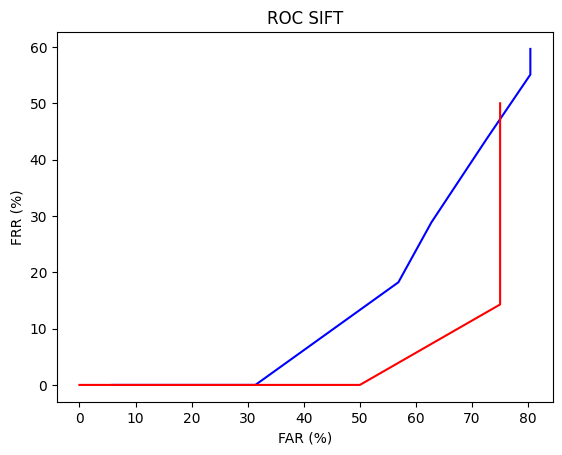

In [27]:
from sklearn.metrics import auc

plot_graph(tpr_train, fpr_train, title="ROC SIFT", label="ROC SIFT - Train", color='blue')

plot_graph(tpr_test, fpr_test, title="ROC SIFT", label="ROC SIFT - Test", color='red')

fpr_train = [x / 100 for x in fpr_train]
tpr_train = [x / 100 for x in tpr_train]
fpr_test = [x / 100 for x in fpr_test]
tpr_test = [x / 100 for x in tpr_test]

auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

print(f"AUC - Train: {auc_train}")
print(f"AUC - Test: {auc_test}")

Los valores obtenidos de AUC son 0.3 tanto para los conjuntos de entrenamiento como de prueba. Esto sugiere que el modelo está clasificando incorrectamente más de lo que lo haría de manera aleatoria. Un posible problema podría ser la cantidad de muestras, pero debido al largo tiempo de entrenamiento, decidimos mantener esta opción. Los resultados son algo confusos, ya que la tasa de EER parece baja (alrededor de 0.3-0.4), pero esto podría deberse a la escasez de muestras. Verificaremos esta hipótesis en los siguientes métodos.

## Obtener descriptores para entrenamiento con SVM

In [11]:
def get_descriptors(image):
    sift = cv.SIFT_create(nfeatures=3500)
    max_descriptors = 3500
    kp, des = sift.detectAndCompute(image, None)
    if des.shape[0] > max_descriptors:
        des = des[:max_descriptors]
    return des

Para probar nuestra segunda hipótesis con SVM, era necesario encontrar una forma de reducir la dimensionalidad de las imágenes para el entrenamiento. Una de las primeras ideas fue utilizar los descriptores de SIFT como entrada. Para ello, la función get_descriptors() solo obtiene los descriptores generados por SIFT. En algunos casos, el número de descriptores obtenidos superaba el máximo especificado de 3500, por lo que era necesario recortarlos hasta ese número. Es fundamental que todos los descriptores de las imágenes tengan la misma dimensión para poder entrenar con SVM.

## Crear dataset para entrenamiento SVM

En la hipótesis se mencionaba que era necesario entrenar el modelo con base en un único usuario, por lo que era necesario crear un dataset. La función create_dataset() toma una lista de archivos y, según el identificador especificado (target), asigna las etiquetas 0 (si el archivo no contiene el identificador, lo que significa que se rechazaría) y 1 (si el archivo contiene el identificador, lo que implica que se aceptaría). Por defecto, entrenaremos el modelo utilizando las imágenes 0811.

In [4]:
def create_dataset(files, target='0811'):
    labels = []
    for file in files:
        if target in file:
            label = 1
        else:
            label = 0
        labels.append(label)

    return labels

labels = create_dataset(pre_rotated_files)

print(pre_rotated_files)
print(labels)

['crd_0811f_01_0.png', 'crd_0811f_01_180.png', 'crd_0811f_01_270.png', 'crd_0811f_01_90.png', 'crd_0811s_01_0.png', 'crd_0811s_01_180.png', 'crd_0811s_01_270.png', 'crd_0811s_01_90.png', 'crd_0812f_01_0.png', 'crd_0812f_01_180.png', 'crd_0812f_01_270.png', 'crd_0812f_01_90.png', 'crd_0812s_01_0.png', 'crd_0812s_01_180.png', 'crd_0812s_01_270.png', 'crd_0812s_01_90.png', 'crd_0813f_01_0.png', 'crd_0813f_01_180.png', 'crd_0813f_01_270.png', 'crd_0813f_01_90.png', 'crd_0813s_01_0.png', 'crd_0813s_01_180.png', 'crd_0813s_01_270.png', 'crd_0813s_01_90.png', 'crd_0814f_01_0.png', 'crd_0814f_01_180.png', 'crd_0814f_01_270.png', 'crd_0814f_01_90.png', 'crd_0814s_01_0.png', 'crd_0814s_01_180.png', 'crd_0814s_01_270.png', 'crd_0814s_01_90.png', 'crd_0815f_01_0.png', 'crd_0815f_01_180.png', 'crd_0815f_01_270.png', 'crd_0815f_01_90.png', 'crd_0815s_01_0.png', 'crd_0815s_01_180.png', 'crd_0815s_01_270.png', 'crd_0815s_01_90.png', 'crd_0816f_01_0.png', 'crd_0816f_01_180.png', 'crd_0816f_01_270.png',

### Preparar datos para entrenamiento de SVM

Se llaman a las funciones descritas anteriormente para cada uno de los archivos preprocesados y rotados, aplanando los descriptores para poder usarlos como vectores de entrada para SVM. Además, las entradas y etiquetas se convierten en un array de NumPy. Es importante mencionar que solo nos quedamos con los archivos 'f', que son los que debemos usar para el entrenamiento."

In [9]:
data = []

pre_rotated_files_f = []

for i in range(len(pre_rotated_files)):
    if 'f' in pre_rotated_files[i]:
        pre_rotated_files_f.append(pre_rotated_files[i])
        img = cv.imread(pre_rotated_path + "/" + pre_rotated_files[i], cv.IMREAD_GRAYSCALE)
        des = get_descriptors(img)
        data.append(des.flatten())

label = create_dataset(pre_rotated_files_f)

prepared_data = np.array(data)
prepared_labels = np.array(labels)

### Entrenamiento SVM usando como entrada descriptores de imágenes

Las etiquetas y los descriptores se unen en un DataFrame de pandas, para posteriormente dividir los datos usando la función train_test_split() de sklearn. La opción stratify permite que la distribución de las clases sea equilibrada en ambos conjuntos. Se añaden al conjunto de test los archivos 's' para compararlos con los 'f'. Un 80% de los archivos de huellas 'f' se usan para el entrenamiento. Se especifican una serie de parámetros para SVM (C, gamma y el tipo de kernel) que permitirán obtener los mejores valores de parámetros de ese conjunto para el modelo usando GridSearchCV(). Tras ello, el modelo se entrena con los datos de entrenamiento y se obtiene una predicción, así como un valor de accuracy para inicialmente valorar si funciona.

In [53]:
import pandas as pd
from sklearn import svm 
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

df = pd.DataFrame(prepared_data)
df['label'] = labels

x = df.drop('label', axis=1)
y = df['label']

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

s_files = [file for file in pre_rotated_files if 's' in file]

x_s = []
for file in s_files:
    img = cv.imread(pre_rotated_path + "/" + file, cv.IMREAD_GRAYSCALE)
    des = get_descriptors(img)
    x_s.append(des.flatten())

x_s = np.array(x_s)
x_test = np.concatenate((x_test, x_s), axis=0)

param_grid={'C':[0.1,1,10,100], 
            'gamma':[0.0001,0.001,0.1,1], 
            'kernel':['rbf','poly']} 
  
svc=svm.SVC(probability=True) 
model=GridSearchCV(svc,param_grid)

model.fit(x_train,y_train)

y_pred = model.predict(x_test) 
accuracy = accuracy_score(y_pred, y_test) 
  
print(f"The model is {accuracy*100}% accurate")

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

La librería joblib nos permite guardar objetos de Python, como el modelo SVM usado en este caso, como 'svm_model_2.pkl'. Esto hace que no sea necesario guardar los valores de clasificación, como en SIFT, donde no existía esta opción.

In [55]:
import joblib

joblib.dump(model, 'svm_model_2.pkl')

['svm_model_2.pkl']

In [58]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       0.00      0.00      0.00         1

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12



C:\Users\Alejandro\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Alejandro\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Alejandro\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

### Curva DET y AUC con SVM

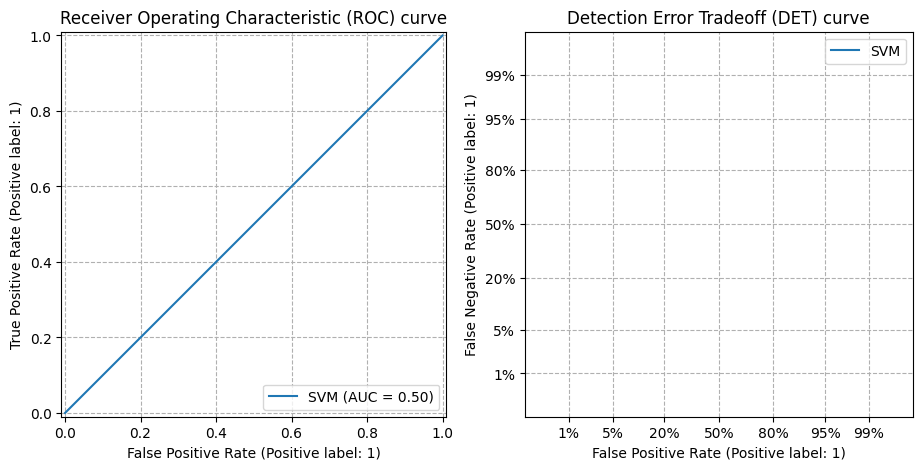

In [63]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

RocCurveDisplay.from_estimator(model, x_test, y_test, ax=ax_roc, name="SVM")

DetCurveDisplay.from_estimator(model, x_test, y_test, ax=ax_det, name="SVM")

ax_roc.set_title("Receiver Operating Characteristic (ROC) curve")
ax_det.set_title("Detection Error Tradeoff (DET) curve")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()

Como vemos, al usar descriptores de SIFT como características, los resultados no son nada buenos y el clasificador actúa de forma aleatoria (AUC: 0.5). Además, parece que la curva DET está vacía, pero puede ser que alguno de los ejes tenga un valor continuo de 1 y el otro de 0.

### Usando PCA

Otra de las alternativas que habíamos considerado en la carrera es PCA (Análisis de Componentes Principales). Para ello, es necesario aplanar las imágenes, para lo que se usa un reshape que crea un vector de tamaño alto por ancho.

In [17]:
data = []

pre_rotated_path = "preprocessed_rotated"

pre_rotated_files = os.listdir(pre_rotated_path)

pre_rotated_files_f = []
for i in range(len(pre_rotated_files)):
    if 'f' in pre_rotated_files[i]:
        pre_rotated_files_f.append(pre_rotated_files[i])
        img = cv.imread(pre_rotated_path + "/" + pre_rotated_files[i], cv.IMREAD_GRAYSCALE)
        #des = get_descriptors(img)
        #data.append(des.flatten())
        data.append(img)

labels = create_dataset(pre_rotated_files_f)

prepared_data = np.array(data)
prepared_data = prepared_data.reshape(prepared_data.shape[0], prepared_data.shape[1] * prepared_data.shape[2])
prepared_labels = np.array(labels)

Se creó una función para calcular las métricas dadas las etiquetas predichas y las reales. La función devuelve la tasa de falsos rechazos, la tasa de falsas aceptaciones, la tasa de verdaderos positivos y la tasa de falsos positivos.

In [15]:
def calculate_metrics(y_test, y_pred):

    va = 0
    fa = 0
    fr = 0
    vr = 0

    intentos_autorizados = 0
    intentos_no_autorizados = 0

    for i in range(len(y_test)):
        if y_test[i] == 1:
            intentos_autorizados += 1
            if y_pred[i] == 1:
                va += 1
            else:
                fr += 1
        else:
            intentos_no_autorizados += 1
            if y_pred[i] == 1:
                fa += 1
            else:
                vr += 1
    
    frr = fr / intentos_autorizados
    far = fa / intentos_no_autorizados
    tpr = va / (va + fr)
    fpr = fa / (fa + vr)

    return frr, far, tpr, fpr

Para usar PCA, es necesario entrenar un objeto con los datos de entrenamiento para reducir la dimensión a n componentes. En este caso, vemos que x_train tiene unas 32 muestras con 160000 características cada una (imagen como vector). Se ha probado con una serie de números de componentes y se ha entrenado SVM tal como en el caso anterior. En este caso, solo probamos con los archivos de f para hacer una primera exploración.

In [19]:
from sklearn.decomposition import PCA
import pandas as pd
from sklearn import svm 
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

x_train, x_test, y_train, y_test = train_test_split(prepared_data, prepared_labels, test_size=0.2, random_state=42, stratify=prepared_labels)

n_components_list = [10, 20, 30]

frr_train_total = []
far_train_total = []
tpr_train_total = []
fpr_train_total = []

frr_test_total = []
far_test_total = []
tpr_test_total = []
fpr_test_total = []

print(x_train.shape)

for n_components in n_components_list:
    pca = PCA(n_components=n_components)

    x_train_transformed = pca.fit_transform(x_train)

    x_test_transformed = pca.transform(x_test)

    param_grid={'C':[0.1,1,10,100], 
                'gamma':[0.0001,0.001,0.1,1], 
                'kernel':['rbf','poly']} 
    
    svc=svm.SVC(probability=True) 

    model=GridSearchCV(svc,param_grid)

    model.fit(x_train_transformed,y_train)

    y_pred_train = model.predict(x_train_transformed)

    frr_train, far_train, tpr_train, fpr_train = calculate_metrics(y_train, y_pred_train)

    y_pred_test = model.predict(x_test_transformed)

    frr_test, far_test, tpr_test, fpr_test = calculate_metrics(y_test, y_pred_test)

    frr_train_total.append(frr_train)
    far_train_total.append(far_train)
    tpr_train_total.append(tpr_train)
    fpr_train_total.append(fpr_train)

    frr_test_total.append(frr_test)
    far_test_total.append(far_test)
    tpr_test_total.append(tpr_test)
    fpr_test_total.append(fpr_test)

(32, 160000)


C:\Users\Alejandro\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Alejandro\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Alejandro\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Los resultados son escritos en un archivo para acceder a ellos con mayor facilidad.

In [20]:

with open("pca_values_train.txt", "w") as file:
    file.write("FAR\n")
    file.write(str(far_train_total) + "\n")
    file.write("FRR\n")
    file.write(str(frr_train_total) + "\n")
    file.write("TPR\n")
    file.write(str(tpr_train_total) + "\n")
    file.write("FPR\n")
    file.write(str(fpr_train_total) + "\n")

with open("pca_values_test.txt", "w") as file:
    file.write("FAR\n")
    file.write(str(far_test_total) + "\n")
    file.write("FRR\n")
    file.write(str(frr_test_total) + "\n")
    file.write("TPR\n")
    file.write(str(tpr_test_total) + "\n")
    file.write("FPR\n")
    file.write(str(fpr_test_total) + "\n")


Tras revisar los datos guardados en los archivos, vemos que el FRR es 1 para todos los componentes, lo que indica que se aceptan a todos los usuarios autorizados. El resto de métricas es 0, lo que indica que nuestro modelo se centra en dar acceso a cualquier entrada. Uno de los intentos para solucionar este problema fue hacer un resize de la imagen y aplanarla para que su vector resultante fuera de menor tamaño, y esta vez entrenar el SVM sin usar PCA, que no estaba siendo de mucha ayuda.

In [22]:
import numpy as np

data = []

for i in range(len(pre_rotated_files_f)):
    img = cv.imread(pre_rotated_path + "/" + pre_rotated_files_f[i], cv.IMREAD_GRAYSCALE)
    img = cv.resize(img, (200, 200)) 
    img_flat = img.flatten()
    data.append(img_flat)

labels = create_dataset(pre_rotated_files_f)

prepared_data = np.array(data)
prepared_labels = np.array(labels)

In [23]:
param_grid={'C':[0.1,1,10,100], 
            'gamma':[0.0001,0.001,0.1,1], 
            'kernel':['rbf','poly']} 

x_train, x_test, y_train, y_test = train_test_split(prepared_data, prepared_labels, test_size=0.2, random_state=42, stratify=prepared_labels)

svc=svm.SVC(probability=True) 

model=GridSearchCV(svc,param_grid)

model.fit(x_train,y_train)

y_pred_train = model.predict(x_train)

frr_train, far_train, tpr_train, fpr_train = calculate_metrics(y_train, y_pred_train)

y_pred_test = model.predict(x_test)

frr_test, far_test, tpr_test, fpr_test = calculate_metrics(y_test, y_pred_test)

frr_train_total.append(frr_train)
far_train_total.append(far_train)
tpr_train_total.append(tpr_train)
fpr_train_total.append(fpr_train)

frr_test_total.append(frr_test)
far_test_total.append(far_test)
tpr_test_total.append(tpr_test)
fpr_test_total.append(fpr_test)

C:\Users\Alejandro\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


In [24]:
print("FRR Train: ", frr_train)
print("FAR Train: ", far_train)
print("TPR Train: ", tpr_train)
print("FPR Train: ", fpr_train)

FRR Train:  1.0
FAR Train:  0.0
TPR Train:  0.0
FPR Train:  0.0


Los datos obtenidos en este caso son muy parecidos a los de PCA, lo que indica que este método nuevamente no es muy útil en nuestra tarea. Si nos fijamos en la curva ROC, obtenemos un valor de 0.5, lo que indica que nuestro clasificador actúa de forma aleatoria (aunque parece en este caso que tiene una gran tasa de falsos positivos), mientras que la curva DET no puede interpretarse.

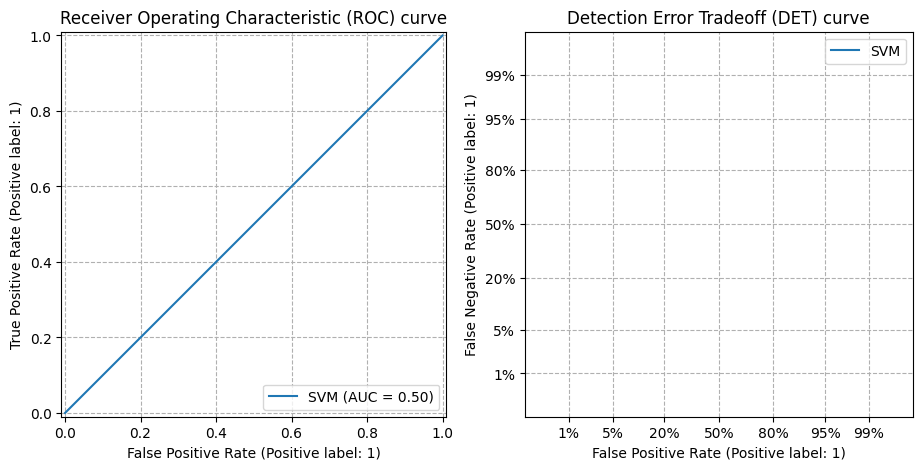

In [37]:
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

RocCurveDisplay.from_estimator(model, x_test, y_test, ax=ax_roc, name="SVM")

DetCurveDisplay.from_estimator(model, x_test, y_test, ax=ax_det, name="SVM")

ax_roc.set_title("Receiver Operating Characteristic (ROC) curve")
ax_det.set_title("Detection Error Tradeoff (DET) curve")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()


## Crear dataset para CNN

El siguiente intento por mejorar el clasificador consistió en crear un encoder con capas convolucionales para convertir la imagen en un vector latente que contenga sus principales características. En el resultado de SIFT se había comentado que uno de los problemas al trazar las curvas era que no fueran del todo representativas debido a la poca cantidad de muestras. Sin embargo, el entrenamiento no permitía añadir muchas más manteniendo el tiempo de cómputo manejable.

En este caso, la función rotate_image_cnn toma una imagen y un ángulo, y crea una imagen con la rotación especificada. Usa la rotación que conocíamos de las prácticas de la primera parte de la asignatura, no la rotación discreta que habíamos empleado para aumentar los datos para SIFT. Se basa en crear una matriz de rotación y aplicarla con la función warpAffine.

Se crean 50 rotaciones para cada imagen f y s en una nueva carpeta rotated_images_cnn.

In [49]:
import random

def rotate_image_cnn(image, angle):

    height, width = image.shape[0], image.shape[1]

    center = (width / 2, height / 2)

    rotation_matrix = cv.getRotationMatrix2D(center, angle, 1.0)

    rotated_image = cv.warpAffine(image, rotation_matrix, (width, height))

    return rotated_image

rotated_path = "rotated_images_cnn"
os.makedirs(rotated_path, exist_ok=True)

for file in filesname_preprocess_f + filesname_preprocess_s:
    print(file)
    image = cv.imread(file, cv.IMREAD_GRAYSCALE)

    #angulos del 1 a 360
    angles = [random.randint(1, 360) for i in range(50)]
    for angle in angles:
        rotated = rotate_image_cnn(image, angle)
        # Crear el nombre del archivo rotado (quitando la extensión .png del nombre original)
        filename = os.path.join(rotated_path, f"{os.path.basename(file)[:-4]}_{angle}.png")
        cv.imwrite(filename, rotated)

    filename = os.path.join(rotated_path, f"{os.path.basename(file)[:-4]}_0.png")
    image = cv.imread(file, cv.IMREAD_GRAYSCALE)
    cv.imwrite(filename, image)

d:\Alejandro\Documents\Universidad\Cuarto\PIAV\Practica semana 9\preprocesado\crd_0811f_01.png
d:\Alejandro\Documents\Universidad\Cuarto\PIAV\Practica semana 9\preprocesado\crd_0812f_01.png
d:\Alejandro\Documents\Universidad\Cuarto\PIAV\Practica semana 9\preprocesado\crd_0813f_01.png
d:\Alejandro\Documents\Universidad\Cuarto\PIAV\Practica semana 9\preprocesado\crd_0814f_01.png
d:\Alejandro\Documents\Universidad\Cuarto\PIAV\Practica semana 9\preprocesado\crd_0815f_01.png
d:\Alejandro\Documents\Universidad\Cuarto\PIAV\Practica semana 9\preprocesado\crd_0816f_01.png
d:\Alejandro\Documents\Universidad\Cuarto\PIAV\Practica semana 9\preprocesado\crd_0817f_01.png
d:\Alejandro\Documents\Universidad\Cuarto\PIAV\Practica semana 9\preprocesado\crd_0818f_01.png
d:\Alejandro\Documents\Universidad\Cuarto\PIAV\Practica semana 9\preprocesado\crd_0819f_01.png
d:\Alejandro\Documents\Universidad\Cuarto\PIAV\Practica semana 9\preprocesado\crd_0820f_01.png
d:\Alejandro\Documents\Universidad\Cuarto\PIAV\Pra

Esta vez, los datos serán la imagen íntegra, que pasará por capas convolucionales de una red neuronal para reducir su dimensión. El resto del código se mantiene muy parecido a lo visto hasta ahora, salvo porque las imágenes se leen desde la nueva carpeta y nuevamente se dividen en dos conjuntos basados en f y s (siendo f el conjunto de entrenamiento). Se utiliza un 80% de los datos de f para entrenar y las imágenes con la etiqueta s se pasan directamente a test.

In [27]:
from sklearn.model_selection import train_test_split 

data_f = []

pre_rotated_path = "rotated_images_cnn"

pre_rotated_files = os.listdir(pre_rotated_path)

pre_rotated_files_f = []
pre_rotated_files_s = []
data_s = []

for i in range(len(pre_rotated_files)):
    if 'f' in pre_rotated_files[i]:
        pre_rotated_files_f.append(pre_rotated_files[i])
        img = cv.imread(pre_rotated_path + "/" + pre_rotated_files[i], cv.IMREAD_GRAYSCALE)
        data_f.append(img)
    elif 's' in pre_rotated_files[i]:
        pre_rotated_files_s.append(pre_rotated_files[i])
        img = cv.imread(pre_rotated_path + "/" + pre_rotated_files[i], cv.IMREAD_GRAYSCALE)
        data_s.append(img)

labels_f = create_dataset(pre_rotated_files_f)
labels_s = create_dataset(pre_rotated_files_s)

prepared_data_f = np.array(data_f)
prepared_data_s = np.array(data_s)

prepared_data_train = prepared_data_f
prepared_labels_train = labels_f
prepared_data_test = prepared_data_s
prepared_labels_test = labels_s

x_train, _, y_train, _ = train_test_split(prepared_data_train, prepared_labels_train, test_size=0.8, random_state=42, stratify=prepared_labels_train)

x_test = prepared_data_test
y_test = prepared_labels_test

Se creó la clase HuellasDataset, que hereda de la clase base Dataset para crear el conjunto de datos que pasará por la red. Un objeto de esta clase podrá usarse como entrada para DataLoader, lo que nos permite obtener conjuntos de datos en batch para entrenar las redes de forma más eficiente. Más tarde, aplicaremos una transformación a las imágenes para facilitar su procesamiento por la red.

In [28]:
from torch.utils.data import Dataset, DataLoader

class HuellasDataset(Dataset):
    def __init__(self, images, labels, transform=None):

        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx])
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

El codificador de imágenes se basa en una arquitectura simple, donde el objetivo es obtener como salida un vector de características de dimensión reducida. Para crear esta red neuronal, debemos hacer que herede de torch.nn.Module.

La primera capa es una convolucional de dos dimensiones con un único canal de entrada (imágenes en escala de grises), generando 16 mapas de características. El tamaño del kernel utilizado para recorrer la imagen es de 3x3. Si nos fijamos en el padding y en el stride, nos desplazamos píxel a píxel y se agrega un píxel alrededor de la imagen para mantener el tamaño espacial. Esta primera capa utiliza como función de activación una ReLU, que permite la no linealidad.

La salida de la capa, tras pasar por la función de activación, llega a una capa de max pooling, donde, con un kernel de 2x2, recorremos la entrada. Esto permite reducir la dimensión, quedándonos con los valores más altos de píxeles en las vecindades de 2x2. En esta operación nos movemos de 2 píxeles en 2, reduciendo la dimensión a la mitad.

La salida de la capa de agrupamiento llega nuevamente a una capa convolucional, donde los 16 mapas de características con resolución reducida se recorrerán con kernels de 3x3 para generar 32 mapas de características. Nuevamente, nos movemos de uno en uno y añadimos un padding de 1 para conservar la dimensión espacial.

La capa lineal tiene como función convertir la salida de las capas anteriores en un vector de características de 128 dimensiones. Para ello, aplanamos la salida de la capa convolucional anterior, que tiene dimensiones 32 (canales de salida) y 64x64 (el tamaño de la imagen al llegar a este punto). El método forward implementa las llamadas a todas estas capas.

De esta manera, conseguimos una nueva representación de la imagen en una dimensión reducida.

In [11]:
import torch.nn as nn

class CNNEncoder(nn.Module):
    def __init__(self):
        super(CNNEncoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1, stride=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1)
        self.fc1 = nn.Linear(in_features=32*64*64, out_features=128)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.fc1(x.view(x.size(0), -1))
        return x

Antes de que la imagen pueda entrar a la red neuronal, se redimensionará a un tamaño de 128x128, lo que la hará más manejable. También es necesario convertirla a un tensor y normalizar sus valores utilizando una media de 0.5 y una desviación estándar de 0.5.

Después, se crean los objetos de Dataset que contienen las imágenes transformadas para los conjuntos de entrenamiento y prueba. Para cargar los datos, se usa un DataLoader que carga los conjuntos de datos en lotes de 16.

In [30]:
import torch
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = HuellasDataset(x_train, y_train, transform=transform)
test_dataset = HuellasDataset(x_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

El código a continuación crea el modelo de encoder y lo carga en la tarjeta gráfica para entrenar con mayor rapidez. Luego, iteramos sobre los lotes de entrenamiento para obtener las representaciones de las imágenes. Para ello, usamos torch.no_grad() para desactivar el cálculo de gradientes y extraer las características. Es importante notar que el encoder no se entrena, ya que no tenemos referencias para esa tarea. En su lugar, probaremos con esta primera idea de abstracción. El vector de características de dimensión reducida se agrega a una nueva lista de características, mientras que las etiquetas (que no sufren cambios) también se añaden.

Tras iterar sobre todos los lotes, concatenamos todas las etiquetas y características. Esto permite tener todas las etiquetas y características en sus respectivos objetos, que son la entrada esperada por la SVM.

In [31]:
model = CNNEncoder()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

all_features_train = []
all_labels_train = []

for images, labels in train_loader:
    images = images.to(device)
    with torch.no_grad():
        features = model(images)
    all_features_train.append(features.cpu())
    all_labels_train.append(labels.cpu())

all_features_train = torch.cat(all_features_train, dim=0)
all_labels_train = torch.cat(all_labels_train, dim=0)

print("Características de entrenamiento:", all_features_train.shape)
print("Etiquetas de entrenamiento:", all_labels_train.shape)

Características de entrenamiento: torch.Size([96, 128])
Etiquetas de entrenamiento: torch.Size([96])


Se repite el proceso anterior para los lotes de test.

In [32]:
all_features_test = []
all_labels_test = []

for images, labels in test_loader:
    images = images.to(device)
    with torch.no_grad():
        features = model(images)
    all_features_test.append(features.cpu())
    all_labels_test.append(labels.cpu())

all_features_test = torch.cat(all_features_test, dim=0)
all_labels_test = torch.cat(all_labels_test, dim=0)

print("Características de prueba:", all_features_test.shape)
print("Etiquetas de prueba:", all_labels_test.shape)

Características de prueba: torch.Size([479, 128])
Etiquetas de prueba: torch.Size([479])


En este paso, los tensores de características y etiquetas se convierten a vectores de numpy, que es la entrada que espera la SVM.

In [33]:
features_train_np = all_features_train.numpy()
labels_train_np = all_labels_train.numpy()

features_test_np = all_features_test.numpy()
labels_test_np = all_labels_test.numpy()

print("Características (entrenamiento) en NumPy:", features_train_np.shape)
print("Etiquetas (entrenamiento) en NumPy:", labels_train_np.shape)

Características (entrenamiento) en NumPy: (96, 128)
Etiquetas (entrenamiento) en NumPy: (96,)


### SVM con vector de características de dimensión reducida generado con CNN.

Para aplicar SVM, procedemos como en los demás casos, donde contamos con un diccionario de parámetros y buscamos el mejor modelo utilizando GridSearchCV. El modelo resultante se entrena con los datos de entrenamiento, que se convierten en un array de numpy, y luego se realiza la predicción sobre los datos de prueba. Para obtener las curvas, usamos los objetos RocCurveDisplay y DetCurveDisplay de from_estimator, que calculan estas curvas para el modelo especificado utilizando las características y las etiquetas reales de test. En cuanto al umbral para DET, corresponde a los valores de probabilidad que determinan el cambio en la clasificación entre la clase positiva y la negativa, y se configura automáticamente.

El modelo es 90.18789144050105% preciso


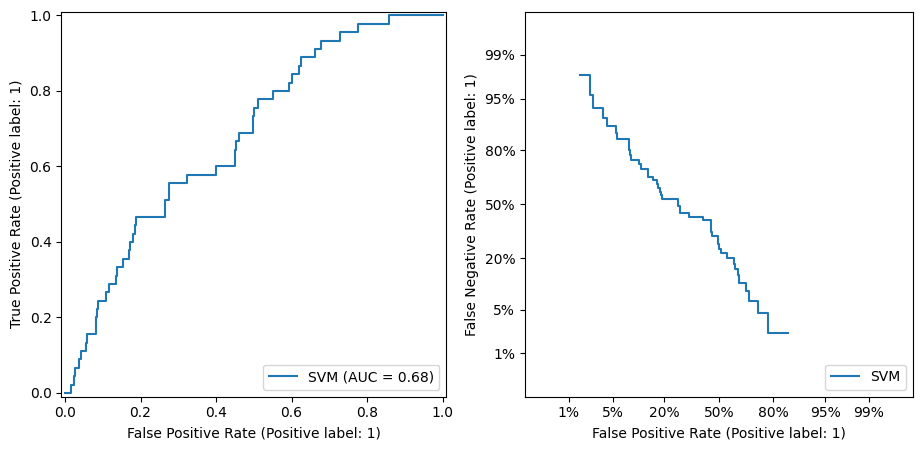

In [48]:
from sklearn.decomposition import PCA
import pandas as pd
from sklearn import svm 
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

param_grid={'C':[0.1,1,10,100], 
            'gamma':[0.0001,0.001,0.1,1], 
            'kernel':['rbf','poly']} 

svc=svm.SVC(probability=True) 

model=GridSearchCV(svc,param_grid)

model.fit(features_train_np, labels_train_np)

predictions = model.predict(features_test_np)
accuracy = accuracy_score(labels_test_np, predictions)
print(f"El modelo es {accuracy*100}% preciso")

fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

RocCurveDisplay.from_estimator(model, features_test_np, labels_test_np, ax=ax_roc, name="SVM")

DetCurveDisplay.from_estimator(model, features_test_np, labels_test_np, ax=ax_det, name="SVM")

Si observamos las curvas para los datos de prueba, estas son mucho más interpretables que las que habíamos visto con SIFT. Ahora contamos con una mayor cantidad de datos, lo que probablemente ha influido positivamente. El valor de AUC obtenido es de 0.68, lo que indica que el clasificador ya no es peor que uno aleatorio. Esto sugiere que el modelo es capaz de discriminar entre las clases negativas y positivas, aunque no lo haga de forma completamente precisa, pero con cierto criterio. El EER se encuentra alrededor de 0.4 en la curva DET, lo que indica que el modelo tiene un punto de equilibrio razonable entre la detección de falsos positivos y falsos negativos. Los resultados son mejores que los obtenidos con SIFT. El valor de accuracy alcanzado es del 90.61%, lo que significa que la mayoría de las muestras se clasifican correctamente, aunque es probable que el modelo sufra un sesgo hacia la clasificación negativa.

## Completar red neuronal

Como ya habíamos creado un encoder y para añadir una hipótesis alternativa que se pudiera comparar con las gráficas anteriores, se agregó un clasificador al encoder de CNN. La clase CNNClassifier obtiene las características del encoder y luego las pasa por el clasificador para devolver una etiqueta. El vector de características de 128 elementos pasa por una capa lineal que reduce las dimensiones a 64 y las pasa a la función de activación ReLU para aplicar no linealidad. Después, se descartan aleatoriamente algunas neuronas para evitar sobreajuste. Por último, las 64 características pasan por otra capa lineal que tendrá como salida un único valor, el cual proporcionará la probabilidad de pertenecer a una de las dos clases.

In [13]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.encoder = CNNEncoder()
        
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1)
        )
    
    def forward(self, features):
        
        output = self.classifier(features)
        
        return output

Al igual que para el encoder, creamos un objeto para el clasificador y lo añadimos a la GPU para mayor rapidez en el entrenamiento. Para el entrenamiento, como función de pérdida se usa la entropía cruzada binaria, que aplica la sigmoide para convertir el valor entre 0 y 1. El optimizador durante el entrenamiento es Adam, que ajustará dinámicamente los pesos del modelo en función de los gradientes calculados durante la retropropagación.

Los datos se cargan utilizando el DataLoader, como en los casos anteriores. Se aplican 10 épocas para entrenar el modelo, donde las entradas son las features. En cada iteración se reinician los gradientes, se calculan a partir de la retropropagación y se actualizan los pesos. En cada época podemos ver la pérdida del entrenamiento. En este caso, la pérdida pasa en 10 épocas de 0.59 a 0.29.

In [50]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

model_classifier = CNNClassifier()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_classifier.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_classifier.parameters(), lr=0.001)

features_train_tensor = torch.tensor(features_train_np, dtype=torch.float32)
labels_train_tensor = torch.tensor(labels_train_np, dtype=torch.float32)

features_test_tensor = torch.tensor(features_test_np, dtype=torch.float32)
labels_test_tensor = torch.tensor(labels_test_np, dtype=torch.float32)


train_dataset = TensorDataset(features_train_tensor, labels_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(features_test_tensor, labels_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


num_epochs = 10
for epoch in range(num_epochs):
    model_classifier.train()
    running_loss = 0.0
    
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device).float()
        
        outputs = model_classifier(features).squeeze()
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Época {epoch + 1}, Pérdida: {running_loss / len(train_loader)}")


model_classifier.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device).float()
        outputs = model_classifier(features).squeeze()
        probs = torch.sigmoid(outputs)
        predictions = (probs >= 0.5).long()
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Precisión en el conjunto de prueba: {accuracy * 100:.2f}%")

Época 1, Pérdida: 0.6536026199658712
Época 2, Pérdida: 0.6084378957748413
Época 3, Pérdida: 0.575806180636088
Época 4, Pérdida: 0.535837709903717
Época 5, Pérdida: 0.5125572681427002
Época 6, Pérdida: 0.47394047180811566
Época 7, Pérdida: 0.4399137298266093
Época 8, Pérdida: 0.41983816027641296
Época 9, Pérdida: 0.40917931993802387
Época 10, Pérdida: 0.3750440577665965
Precisión en el conjunto de prueba: 90.61%


En el código anterior, realizábamos una pequeña prueba sobre el conjunto de test, aunque esta misma prueba se repite en el siguiente código. El modelo pasa a modo de evaluación, desactivando, por ejemplo, el dropout que usábamos para evitar el sobreajuste. Se itera sin calcular ni almacenar los gradientes sobre el cargador de datos de test. Se obtiene el resultado del modelo (usando squeeze para obtener un número y no un tensor). Sobre estas salidas, se aplica la función sigmoide para obtener las probabilidades de pertenecer a la clase positiva. Las predicciones se convierten a 0 o 1 en función de si superan el valor umbral de 0.5 en la probabilidad. Tras ello, pasamos las predicciones, etiquetas y probabilidades a un formato de numpy para poder obtener los valores necesarios para generar las curvas ROC y DET. El valor de accuracy obtenido es de 90.61%, por lo que la mayoría de las muestras se clasifican correctamente (aunque seguramente denegando el acceso).

En esta ocasión, usaremos las funciones roc_curve y det_curve de sklearn para obtener los valores que componen las curvas de los datos de test y representarlas con RocCurveDisplay() y DetCurveDisplay(). Podemos comprobar en este paso los valores de umbral creados automáticamente por det_curve, que se mueven en valores alrededor de 0.2. Por lo que parece, requiere un umbral bajo para clasificar como positivo y dar acceso.

Thresholds:  [0.20429903 0.20463869 0.20473303 0.20473404 0.20473906 0.20485175
 0.20494787 0.20508207 0.20515527 0.20528711 0.2053457  0.20543696
 0.20546648 0.20552504 0.20593192 0.20594373 0.20604837 0.2061385
 0.20623629 0.20627353 0.20634893 0.20644394 0.20647076 0.20649609
 0.2066116  0.20678858 0.20691901 0.20700759 0.20701084 0.20707025
 0.20728414 0.20731634 0.2073578  0.20748007 0.20752543 0.2075395
 0.20754531 0.20758031 0.20773932 0.2077633  0.20782734 0.20789155
 0.2080155  0.20807692 0.20814398 0.20825057 0.20826621 0.20836763
 0.20839597 0.20846575 0.20851678 0.20856361 0.20869099 0.20872767
 0.20894547 0.20895594 0.20896198 0.20925175 0.20929316 0.2093119
 0.2093925  0.20943858 0.20949528 0.20951448 0.2095286  0.20958292
 0.20969734 0.20971985 0.20975289 0.20982347 0.2099135  0.20992324
 0.21001132 0.2101578  0.21037245 0.21040714 0.21048993 0.21060254
 0.2106185  0.21062009 0.21071614 0.2107434  0.21075043 0.21077365
 0.21105081 0.21112323 0.211131   0.2112212  0.21123

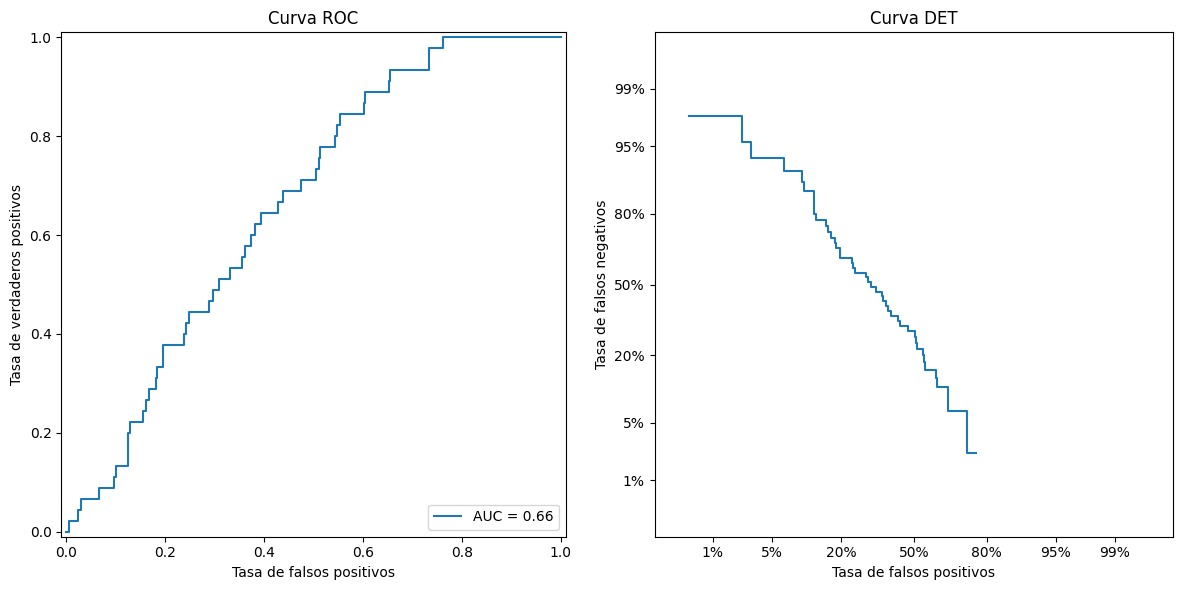

Precisión en el conjunto de prueba: 90.61%


In [49]:
from sklearn.metrics import roc_curve, auc, det_curve

model_classifier.eval()
all_predictions = []
all_labels = []
all_probs = []

with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device).float()
        outputs = model_classifier(features).squeeze()
        probs = torch.sigmoid(outputs)
        predictions = (probs >= 0.5).long()
        
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

fpr_det, fnr_det, threeshold_det = det_curve(all_labels, all_probs)

print("Thresholds: ", threeshold_det)

fig, (ax_roc, ax_det) = plt.subplots(1, 2, figsize=(12, 6))

RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot(ax=ax_roc)
DetCurveDisplay(fpr=fpr_det, fnr=fnr_det).plot(ax=ax_det)

ax_roc.set_xlabel('Tasa de falsos positivos')
ax_roc.set_ylabel('Tasa de verdaderos positivos')
ax_roc.set_title('Curva ROC')

ax_det.set_xlabel('Tasa de falsos positivos')
ax_det.set_ylabel('Tasa de falsos negativos')
ax_det.set_title('Curva DET')

plt.tight_layout()
plt.show()

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Precisión en el conjunto de prueba: {accuracy * 100:.2f}%")

Si nos fijamos, la curva AUC parece no basarse en un descriptor aleatorio y obtenemos un valor de 0.66, que es algo peor que el de SVM, pero mejor que el de SIFT. En cuanto a la curva DET, se podría decir que el valor de EER es cercano a 0.4, indicando nuevamente que el modelo tiene un punto de equilibrio razonable entre la detección de falsos positivos y la de falsos negativos, aunque sigue siendo muy mejorable.

## Comparación curvas DET y ROC entre SVM y clasificador Red Neuronal

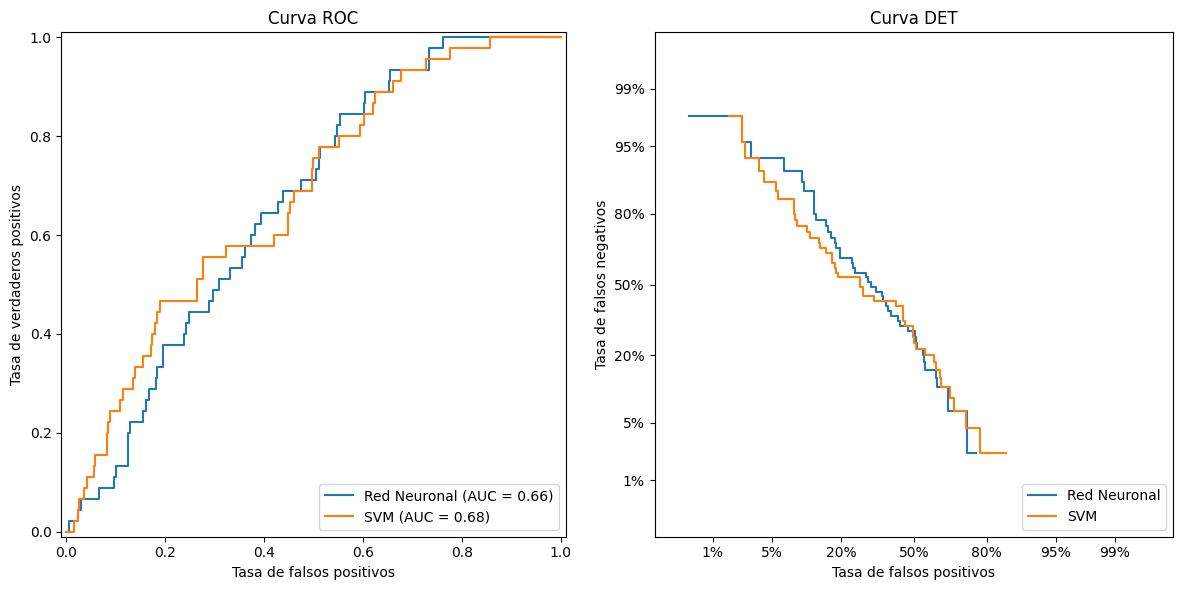

In [44]:
fig, (ax_roc, ax_det) = plt.subplots(1, 2, figsize=(12, 6))

RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot(ax=ax_roc, label= f"Red Neuronal (AUC = {roc_auc:.2f})")
DetCurveDisplay(fpr=fpr_det, fnr=fnr_det).plot(ax=ax_det, label="Red Neuronal")
RocCurveDisplay.from_estimator(model, features_test_np, labels_test_np, ax=ax_roc, name="SVM")
DetCurveDisplay.from_estimator(model, features_test_np, labels_test_np, ax=ax_det, name="SVM")

ax_roc.set_xlabel('Tasa de falsos positivos')
ax_roc.set_ylabel('Tasa de verdaderos positivos')
ax_roc.set_title('Curva ROC')

ax_det.set_xlabel('Tasa de falsos positivos')
ax_det.set_ylabel('Tasa de falsos negativos')
ax_det.set_title('Curva DET')

plt.tight_layout()
plt.show()

Ambas curvas son bastante parecidas y no hay grandes diferencias, ni en el AUC (0.6) ni en el DET (en ambos casos parece cercano a 0.4). Por lo tanto, podemos concluir que los clasificadores creados a partir de representaciones de la imagen reducida por un codificador basado en capas convolucionales dan resultados aceptables. El método de SIFT era mucho más complicado de entrenar, y la única ventaja positiva era que el umbral era directamente controlable. En este caso, la única medida de distancia que tenemos es la probabilidad de que las imágenes sean de la misma clase. Sin embargo, los resultados de SIFT eran confusos.

El preprocesamiento, en un principio, también pudo haber sido muy rebuscado; sin embargo, con este enfoque más simple hemos obtenido mejores resultados.

### Guardando modelos

Primero guardamos el modelo de SVM con joblib:

In [56]:
import joblib

joblib.dump(model, 'svm_model_cnn.pkl')

['svm_model_cnn.pkl']

El modelo de Red Neuronal puede ser almacenado con:

In [ ]:
torch.save(model_classifier.state_dict(), 'classifier_model_nn.pth')

### Predecir una imagen:

Para predecir si una imagen tiene acceso o no a nuestro sistema, se ha creado una nueva función. Nuestros modelos han sido entrenados para aceptar las huellas con el identificador 0811, por lo que el resto debería ser rechazado. Se han creado funciones tanto para la SVM como para el clasificador de red neuronal. Las imágenes se cargan como tensor usando la librería PIL y la función Image una vez han sido preprocesadas. Se añade una primera dimensión al tensor (la de batch) para poder procesarla con el encoder, y se predice según el modelo. La función del clasificador de red neuronal nos permite especificar el umbral que queremos emplear para determinar si se acepta o rechaza la muestra según su probabilidad. Como vemos, en este caso todas las muestras son rechazadas, incluso las del propio identificador.

In [15]:
import joblib
from PIL import Image
import cv2 as cv
import numpy as np
from torchvision import transforms
import torch


transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

def authenticate_svm(img):

    model = joblib.load('svm_model_cnn.pkl')

    img = cv.imread(img, cv.IMREAD_GRAYSCALE)
    img_pre = obtain_preprocessed_image(img) 

    img_pre = Image.fromarray(img_pre)

    img_tensor = transform(img_pre).unsqueeze(0)


    encoder = CNNEncoder()
    features = encoder(img_tensor)
    
    features_np = features.detach().numpy()

    prediction = model.predict(features_np)
    
    if prediction == 1:
        print("La huella es válida.")
        print("La probabilidad obtenida es: ", model.predict_proba(features_np))
    
    else:
        print("La huella no es válida.")
        print("La probabilidad obtenida es: ", model.predict_proba(features_np))

authenticate_svm(r"preprocessed_rotated\crd_0813s_01_270.png")
authenticate_svm(r"preprocessed_rotated\crd_0813s_01_0.png")
authenticate_svm(r"rotated_images_cnn\crd_0811s_01_264.png")

def authenticate_nn(img, umbral=0.2):
    model_classifier = CNNClassifier()
    model_classifier.load_state_dict(torch.load('classifier_model_nn.pth'))

    img = cv.imread(img, cv.IMREAD_GRAYSCALE)
    img_pre = obtain_preprocessed_image(img)

    img_pre = Image.fromarray(img_pre)

    img_tensor = transform(img_pre).unsqueeze(0)

    encoder = CNNEncoder()
    features = encoder(img_tensor)

    outputs = model_classifier(features)
    probs = torch.sigmoid(outputs)
    predictions = (probs >= umbral).long()

    if predictions == 1:
        print("La huella es válida.")
        print("La probabilidad obtenida es: ", probs.item())
    else:
        print("La huella no es válida.")
        print("La probabilidad obtenida es: ", probs.item())

authenticate_nn(r"preprocessed_rotated\crd_0813s_01_270.png")
authenticate_nn(r"preprocessed_rotated\crd_0813s_01_0.png")
authenticate_nn(r"rotated_images_cnn\crd_0811s_01_0.png")



La huella no es válida.
La probabilidad obtenida es:  [[0.95433113 0.04566887]]
La huella no es válida.
La probabilidad obtenida es:  [[0.95153068 0.04846932]]
La huella no es válida.
La probabilidad obtenida es:  [[0.9518395 0.0481605]]


C:\Users\Alejandro\AppData\Local\Temp\ipykernel_10268\898354005.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_classifier.load_state_dict(torch.load('classifier_

La huella es válida.
La probabilidad obtenida es:  0.4839874505996704
La huella es válida.
La probabilidad obtenida es:  0.48830971121788025
La huella es válida.
La probabilidad obtenida es:  0.4514825940132141
